# **Fraud Detection on Synthetic Financial Dataset**

##  Part 1: Data Loading

In [ ]:
import os
import networkx as nx
import pandas as pd
import numpy as np
import random
import itertools
import math
import random
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive=drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Access to the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLNS/Project_Anti fraud/PS_20174392719_1491204439457_log.csv')

# Columns
# step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
# type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
# amount -amount of the transaction in local currency.
# nameOrig - customer who started the transaction
# oldbalanceOrg - initial balance before the transaction
# newbalanceOrig - new balance after the transaction
# nameDest - customer who is the recipient of the transaction
# oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
# newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
# isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
# isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [ ]:
print('All types: ',list(data['type'].drop_duplicates().values))

All types:  ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']


In [ ]:
print('isFraud type', list(data[data.isFraud==1]['type'].drop_duplicates().values))
print('isFlaggedFraud type', list(data[data.isFlaggedFraud==1]['type'].drop_duplicates().values))
print('All transactions ', len(data))
print('isFraud transactions ', len(data[data.isFraud==1]))
print('- isFraud-TRANSFER transactions ', len(data[(data.isFraud==1)&(data['type']=='TRANSFER')]))
print('- isFraud-CASH_OUT transactions ', len(data[(data.isFraud==1)&(data['type']=='CASH_OUT')]))
print('isFlaggedFraud transactions ', len(data[data.isFlaggedFraud==1]))
# with isFlaggedFraud number is only 16, we decide to ignore those values

isFraud type ['TRANSFER', 'CASH_OUT']
isFlaggedFraud type ['TRANSFER']
All transactions  6362620
isFraud transactions  8213
- isFraud-TRANSFER transactions  4097
- isFraud-CASH_OUT transactions  4116
isFlaggedFraud transactions  16


In [ ]:
# We only care about TRANSFER and CASH_OUT, because these are the two types where frauds happen
df_select = data.loc[(data['type']=='TRANSFER')|(data['type']=='CASH_OUT')]

# All transaction starter and transaction receiver
list_of_senders = list(df_select['nameOrig'])
list_of_dest = list(df_select['nameDest'])

# fraud transaction 
dd_fraud=df_select.loc[df_select['isFraud']==1]
# fraud transaction starter and transaction receiver
list_of_senders_victom = list(dd_fraud["nameOrig"])
list_of_dest_fraud=list(dd_fraud["nameDest"])

# normal transaction 
dd_benign=df_select.loc[df_select['isFraud']==0]
# normal transaction starter and transaction receiver
list_of_senders_benign =list(dd_benign["nameOrig"])
list_of_dest_benign=list(dd_benign["nameDest"])

In [ ]:
print(len(np.unique(list_of_senders)))
print(len(np.unique(list_of_dest)))

2768630
509565


In [ ]:
# Normalize Amount
from sklearn.preprocessing import StandardScaler
# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler on the amount column
scaler.fit(df_select[['amount']])
# transform the amount column using the scaler
df_select['normalized_amount'] = scaler.transform(df_select[['amount']])

<ipython-input-9-16c3c762f158>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['normalized_amount'] = scaler.transform(df_select[['amount']])


### Orignal Graph View

In [ ]:
# Creating Graph using only the TRANSFER and CASH_OUT data
G = nx.from_pandas_edgelist(df_select, 'nameOrig', 'nameDest', edge_attr=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
                            , create_using=nx.DiGraph())
# Print some basic information about the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 3277509
Number of edges: 2770409


### Ego network - see node level

In [ ]:
df_select.loc[df_select['nameDest']=='C553264065']

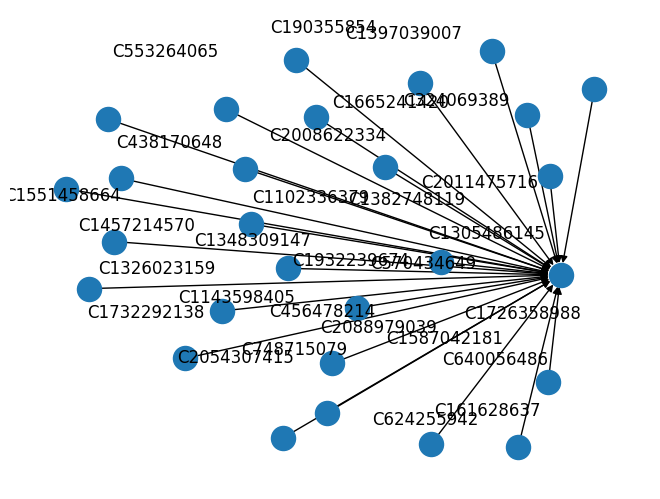

In [ ]:
# Create Ego network, see connections in NODE-LEVEL
# take one fraud example,'C553264065' is the nameDest in a fraud transaction
egog = nx.ego_graph(G,'C553264065',radius =1, center=True, undirected=True)
nx.draw(egog)
labels=nx.draw_networkx_labels(egog,pos=nx.spring_layout(egog))
plt.show()

In [ ]:
# test and flagged results
list_of_flaged=nx.nodes(egog)
flagged=set(list_of_flaged)
fraud=set(list_of_dest_fraud)
fraud.intersection(flagged)

{'C553264065'}

## Part2 Data Sampling & Feature Extractor(Negative Sampling)

### Imbalanced Dataset - Negative Sampling
As our dataset is so imbalanced, we implemented negative sampling to generate new dataset.

In [ ]:
train_pre, test_pre = train_test_split(df_select, test_size=0.2, random_state=42)
train_pre['isFraud'].sum()

6567

In [ ]:
# shuffle dafaframe rows
train_pre = train_pre.sample(frac=1)
# we have 8213 fraud transactions
fraud_df = train_pre.loc[train_pre['isFraud'] == 1]
non_fraud_df = train_pre.loc[train_pre['isFraud'] == 0][:656700] # isfruad : nonfraud = 1:10

normal_distributer_df = pd.concat([fraud_df, non_fraud_df])

# shuffle dafaframe rows
new_df = normal_distributer_df.sample(frac=1, random_state=42)

new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,normalized_amount
1567294,155,CASH_OUT,21403.60,C1967969462,0.00,0.0,C1790153472,235794.99,257198.59,0,0,-0.333562
4440623,323,TRANSFER,3437405.72,C2001496484,125911.88,0.0,C292894580,11020656.15,14458061.87,0,0,3.514200
2186273,185,CASH_OUT,51040.34,C1514631696,0.00,0.0,C1070134883,141819.25,192859.59,0,0,-0.300179
5235146,371,CASH_OUT,173903.69,C1176799529,26072.00,0.0,C1751508861,0.00,173903.69,0,0,-0.161787
5103434,355,CASH_OUT,254862.18,C461452238,30474.00,0.0,C1261999650,0.00,254862.18,0,0,-0.070596


In [ ]:
# the fraud and non-fraud transactions in new_df
print('nonFraud transactions ', len(new_df[new_df.isFraud==0]))
print('isFraud transactions ', len(new_df[new_df.isFraud==1]))

nonFraud transactions  656700
isFraud transactions  6567


In [ ]:
# Here we split transactions into training and test sets randomly
train, test_df = train_test_split(new_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)
# print the sizes of the training and test sets
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

Training set size: 424490
Validation set size: 106123
Test set size: 132654


<ipython-input-146-d385f870509a>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),annot=True,cmap='hot')


<Axes: >

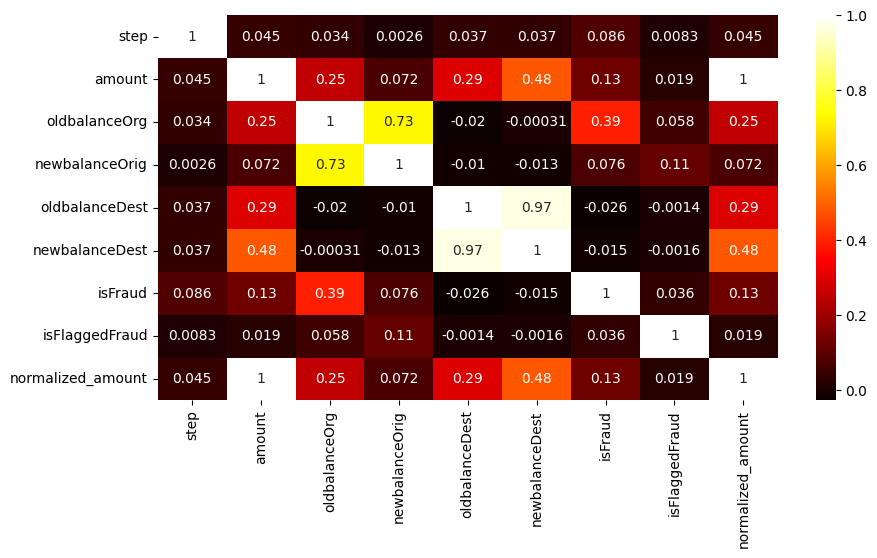

In [ ]:
# Import seaborn
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(),annot=True,cmap='hot')

In [ ]:
# prepare training and test data
train_samples = [(row['nameOrig'], row['nameDest'],row['amount']) for _, row in train_df.iterrows()]
train_labels = [(row['isFraud']) for _, row in train_df.iterrows()]

test_samples = [(row['nameOrig'], row['nameDest'],row['amount']) for _, row in test_df.iterrows()]
test_labels = [(row['isFraud']) for _, row in test_df.iterrows()]


print('fraud in train samples', sum(train_labels),'/',len(train_labels))
print('fraud in test samples', sum(test_labels),'/',len(test_labels))

fraud in train samples 4181 / 424490
fraud in test samples 1334 / 132654


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []

    # --- Extract manually diverse features relative to each edge contained in samples --- 
    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(graph)
    
    # Calculate approximate betweenness centrality, set k<num_nodes to reduce calculation cost
    # approx_centrality = nx.betweenness_centrality(graph,k=200000)

    # Page Rank Measure
    page_rank = nx.pagerank(graph)
    
    for edge in tqdm(samples):

        source_node, target_node=edge[0], edge[1]
        edge_data = G.get_edge_data(source_node, target_node)
        if edge_data is not None:
            amount=edge_data.get('amount')
            oldbalanceOrg=edge_data.get('oldbalanceOrg')
            newbalanceOrig=edge_data.get('newbalanceOrig')
            oldbalanceDest=edge_data.get('oldbalanceDest')
            newbalanceDest=edge_data.get('newbalanceDest')
        else:
        # handle the case where there is no edge between u and v
            amount=0
            oldbalanceOrg=0
            newbalanceOrig=0
            oldbalanceDest=0
            newbalanceDest=0
        

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Clustering coefficient
        clustering_coefficient = nx.clustering(G, source_node)  
        
        # Betweeness centrality measure 
        # diff_bt = approx_centrality[target_node] - approx_centrality[source_node]

        # Page Rank measure
        page_rank_source, page_rank_target = page_rank[source_node],page_rank[target_node]
        # paiwise pagerank
        pagerank_ratio = page_rank_source / page_rank_target 

        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([
                                        source_degree_centrality, target_degree_centrality,
                                        clustering_coefficient,
                                        amount,
                                        oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest
                                        # ,second_shortest_path
                                        # ,diff_bt 
                                        ,page_rank_source,page_rank_target
                                        , pagerank_ratio 
                                        # ,source_triangles,target_triangles
                                        # ,eigenvector_centrality_source,eigenvector_centrality_target
                                        ])) 
    return feature_vector

In [ ]:
# Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(G, train_samples)
test_features = feature_extractor(G, test_samples)

100%|██████████| 132654/132654 [00:03<00:00, 41267.29it/s]


In [ ]:
# test on original dataset
test_pre_samples = [(row['nameOrig'], row['nameDest'],row['amount']) for _, row in test_pre.iterrows()]
test__pre_labels = [(row['isFraud']) for _, row in test_pre.iterrows()]
test_pre_features = feature_extractor(G, test_pre_samples)

100%|██████████| 554082/554082 [00:14<00:00, 37352.83it/s]


## Part3: Model & Evaluation


### LogisticRegression

test on testset after negative sampling

In [ ]:
from sklearn.metrics import fbeta_score
# simple LogisticRegression
def prediction(graph, train_features, test_features, train_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    # --- Build the model and train it ---
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]

    test_preds = clf.predict(test_features)
    
    return test_preds

test_preds = prediction(G, train_features, test_features, train_labels)
print('how many frauds exist: ',test_labels.count(1))
print('how many frauds are detected: ',test_preds.tolist().count(1))



# Evaluate the model

# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()

# calculate TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

precision = tp / (tp + fp)

# print the results
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("False Negative Rate (FNR):", fnr)

print("Precision Rate:", precision)
print('F2 score: ',fbeta_score(test_labels, test_preds, average='binary', beta=2))


how many frauds exist:  1334
how many frauds are detected:  1655
True Positive Rate (TPR): 0.7863568215892054
False Positive Rate (FPR): 0.0046146816935729515
False Negative Rate (FNR): 0.2136431784107946
Precision Rate: 0.6338368580060423
F2 score:  0.7502503218423687


test on original's testset

In [ ]:
# simple LogisticRegression
def prediction(graph, train_features, test_features, train_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    # --- Build the model and train it ---
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    # train_preds = clf.predict_proba(train_features)[:, 1]

    test_preds = clf.predict(test_features)
    
    return test_preds

test_preds = prediction(G, train_features, test_pre_features, train_labels)
print('how many frauds exist: ',test__pre_labels.count(1))
print('how many frauds are detected: ',test_preds.tolist().count(1))

# Evaluate the model

# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(test__pre_labels, test_preds).ravel()

# calculate TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
precision = tp / (tp + fp)

# print the results
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("False Negative Rate (FNR):", fnr)

print("Precision Rate:", precision)
print('F2 score: ',fbeta_score(test__pre_labels, test_preds, average='binary', beta=2)) # F2 score:  0.10639710079515736


how many frauds exist:  1646
how many frauds are detected:  3898
True Positive Rate (TPR): 0.7867557715674363
False Positive Rate (FPR): 0.004711858025183008
False Negative Rate (FNR): 0.2132442284325638
Precision Rate: 0.33222165212929705
F2 score:  0.617725624880748


### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def prediction(graph, train_features, test_features, train_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    # --- Build the model and train it ---
    clf = RandomForestClassifier(n_estimators=300, max_depth=4, random_state=42)
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]

    test_preds = clf.predict(test_features)
    
    return test_preds

test_preds = prediction(G, train_features, test_features, train_labels)

print('how many frauds exist: ',test_labels.count(1))

print('how many frauds are detected: ',test_preds.tolist().count(1))

# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
# calculate TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
precision = tp / (tp + fp)

# print the results
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("False Negative Rate (FNR):", fnr)
print("Precision Rate:", precision)

how many frauds exist:  1334
how many frauds are detected:  777
True Positive Rate (TPR): 0.5757121439280359
False Positive Rate (FPR): 6.853487663722205e-05
False Negative Rate (FNR): 0.424287856071964
Precision Rate: 0.9884169884169884


In [ ]:
# test on original test
def prediction(graph, train_features, test_features, train_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    # --- Build the model and train it ---
    clf = RandomForestClassifier(n_estimators=300, max_depth=4, random_state=42)
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]

    test_preds = clf.predict(test_features)
    
    return test_preds

test_preds = prediction(G, train_features, test_pre_features, train_labels)
print('how many frauds exist: ',test__pre_labels.count(1))
print('how many frauds are detected: ',test_preds.tolist().count(1))

# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(test__pre_labels, test_preds).ravel()
# calculate TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
precision = tp / (tp + fp)

# print the results
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("False Negative Rate (FNR):", fnr)
print("Precision Rate:", precision)
print('F2 score: ',fbeta_score(test__pre_labels, test_preds, average='binary', beta=2)) # F2 score:  0.19315575939319102


how many frauds exist:  1646
how many frauds are detected:  993
True Positive Rate (TPR): 0.5735115431348724
False Positive Rate (FPR): 8.869805733152799e-05
False Negative Rate (FNR): 0.4264884568651276
Precision Rate: 0.9506545820745217
F2 score:  0.6229378381945361


### XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

def prediction(graph, train_features, test_features, train_labels):
    
    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(train_features, label=train_labels)
    dtest = xgb.DMatrix(test_features)
    # Set parameters for XGBoost model
    params = {'max_depth': 5, 'eta': 0.01, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
    # Train the XGBoost model
    num_rounds = 100
    clf = xgb.train(params, dtrain, num_rounds)
    test_preds = clf.predict(dtest)
    test_preds = [1 if p > 0.5 else 0 for p in test_preds]
    return test_preds

test_preds = prediction(G, train_features, test_features, train_labels)
print('how many frauds exist: ',test_labels.count(1))

print('how many frauds are detected: ',test_preds.count(1))

# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
# calculate TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
precision = tp / (tp + fp)
# print the results
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("Precision Rate:", precision)

how many frauds exist:  1334
how many frauds are detected:  959
True Positive Rate (TPR): 0.6949025487256372
False Positive Rate (FPR): 0.00024367956137678952
Precision Rate: 0.9666319082377477


In [ ]:


# test on original test set

def prediction(graph, train_features, test_features, train_labels):
    
    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(train_features, label=train_labels)
    dtest = xgb.DMatrix(test_features)
    # Set parameters for XGBoost model
    params = {'max_depth': 5, 'eta': 0.01, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
    # Train the XGBoost model
    num_rounds = 100
    clf = xgb.train(params, dtrain, num_rounds)
    test_preds = clf.predict(dtest)
    test_preds = [1 if p > 0.5 else 0 for p in test_preds]
    return test_preds

test_preds = prediction(G, train_features, test_pre_features, train_labels)
print('how many frauds exist: ',test__pre_labels.count(1))
print('how many frauds are detected: ',test_preds.count(1))

# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(test__pre_labels, test_preds).ravel()
# calculate TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
precision = tp / (tp + fp)

# print the results
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("False Negative Rate (FNR):", fnr)
print("Precision Rate:", precision)
print('F2 score: ',fbeta_score(test__pre_labels, test_preds, average='binary', beta=2))# F2 score:  0.2777494302139675

how many frauds exist:  1646
how many frauds are detected:  1266
True Positive Rate (TPR): 0.6901579586877278
False Positive Rate (FPR): 0.00023532137659384978
False Negative Rate (FNR): 0.30984204131227217
Precision Rate: 0.8973143759873617
F2 score:  0.7235668789808916


## Part4: Oversampling Exploration

### Sampling before train_test_Split

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Create a new DataFrame with only the relevant features
#df = df_select[['nameOrig', 'nameDest', 'amount', 'isFraud']]

# Separate the features (X) and labels (y)
X = df_select.drop('isFraud', axis=1)
y = df_select['isFraud']

# Apply oversampling using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Combine the resampled features and labels into a new DataFrame
new_df = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
# Split the data into train, validation, and test sets
train, test_df = train_test_split(new_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Extract the samples and labels for the training and test sets
train_samples = [(row['nameOrig'], row['nameDest'], row['amount']) for _, row in train_df.iterrows()]
train_labels = [(row['isFraud']) for _, row in train_df.iterrows()]

test_samples = [(row['nameOrig'], row['nameDest'], row['amount']) for _, row in test_df.iterrows()]
test_labels = [(row['isFraud']) for _, row in test_df.iterrows()]

In [ ]:
# print the sizes of the training and test sets
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

In [ ]:
print('Frauds after random sampling in the training dataset is ', round(train_df['isFraud'].value_counts()[1] / len(train_df) * 100, 2),'% of the dataset')
print('Frauds after random sampling in the test dataset is ', round(test_df['isFraud'].value_counts()[1] / len(test_df) * 100, 2),'% of the dataset') 

In [ ]:
# Import seaborn
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(),annot=True,cmap='hot')

In [ ]:
# Create feature vector for all edges in training set and test set ---
import time
start_time = time.time()
train_features = feature_extractor(G, train_samples)
test_features = feature_extractor(G, test_samples)
end_time = time.time()
elapsed_time = end_time - start_time
print("Time to extract feature model",elapsed_time)

### Sampling after train_test_Split

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Create a new DataFrame with only the relevant features
#df = df_select[['nameOrig', 'nameDest', 'amount', 'isFraud']]


# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=42)
# train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Separate the features (X) and labels (y)
train_X = train_df.drop('isFraud', axis=1)
train_y = train_df['isFraud']

# Apply oversampling using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(train_X, train_y)

# Combine the resampled features and labels into a new DataFrame
new_train_df = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
# Extract the samples and labels for the training and test sets
train_samples = [(row['nameOrig'], row['nameDest'], row['amount']) for _, row in new_train_df.iterrows()]
train_labels = [(row['isFraud']) for _, row in new_train_df.iterrows()]

test_samples = [(row['nameOrig'], row['nameDest'], row['amount']) for _, row in test_df.iterrows()]
test_labels = [(row['isFraud']) for _, row in test_df.iterrows()]


print('Frauds after random sampling in the training dataset is ', round(new_train_df['isFraud'].value_counts()[1] / len(new_train_df) * 100, 2),'% of the dataset')
print('Frauds after random sampling in the test dataset is ', round(test_df['isFraud'].value_counts()[1] / len(test_df) * 100, 2),'% of the dataset') 